In [2]:
import pandas as pd
import numpy as np

In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

a=api.dataset_download_files('carlmcbrideellis/llm-7-prompt-training-dataset')
# os.system("unzip -v C:/Users/gksxo/Desktop/2023학년도 2학기/오픈소스-조겨리 교수님/기말프로젝트/llm-7-prompt-training-dataset.zip")

import zipfile

zip_path = 'C:/Users/gksxo/Desktop/2023학년도 2학기/오픈소스-조겨리 교수님/기말프로젝트/llm-7-prompt-training-dataset.zip'  # 압축 파일 경로
extract_path = 'C:/Users/gksxo/Desktop/2023학년도 2학기/오픈소스-조겨리 교수님/기말프로젝트'  # 압축 해제 경로

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [14]:
prompt=pd.read_csv("C:/Users/gksxo/Desktop/2023학년도 2학기/오픈소스-조겨리 교수님/기말프로젝트/train_essays_7_prompts_v2.csv")
print(prompt.shape)
prompt.head()

(15350, 2)


,text,label
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [19]:
prompt.isna().sum()

text     0
label    0
dtype: int64

In [9]:
prompt.describe()

,label
count,15350.000000
mean,0.106710
std,0.308754
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [21]:
#1. WORD-COUNT
prompt['word_count'] = prompt['text'].apply(lambda x: len(str(x).split()))
print(prompt[prompt['label']==1]['word_count'].mean()) #Disaster tweets
print(prompt[prompt['label']==0]['word_count'].mean()) #Non-Disaster tweets
#Disaster tweets are more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
prompt['char_count'] = prompt['text'].apply(lambda x: len(str(x)))
print(prompt[prompt['label']==1]['char_count'].mean()) #Disaster tweets
print(prompt[prompt['label']==0]['char_count'].mean()) #Non-Disaster tweets
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
prompt['unique_word_count'] = prompt['text'].apply(lambda x: len(set(str(x).split())))
print(prompt[prompt['label']==1]['unique_word_count'].mean()) #Disaster tweets
print(prompt[prompt['label']==0]['unique_word_count'].mean()) #Non-Disaster tweets

407.523199023199
416.8986289381564
2638.7240537240536
2335.516554842474
222.22649572649573
208.16766336056008


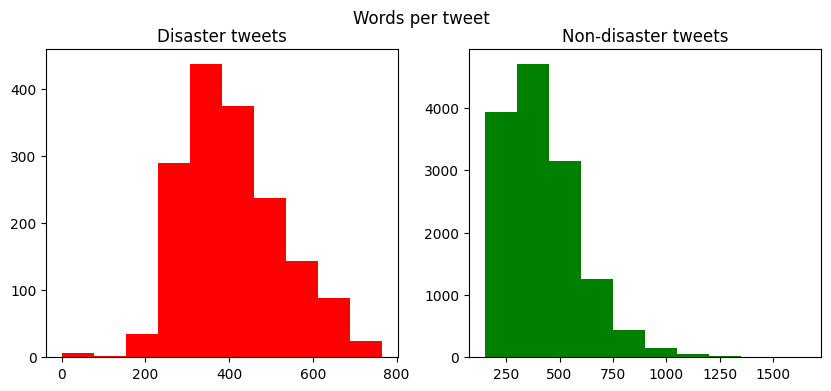

In [22]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=prompt[prompt['label']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=prompt[prompt['label']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [26]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gksxo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gksxo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gksxo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gksxo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [24]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


In [27]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

message cleaned may involve things like adjacent spaces tabs
messag clean may involv thing like adjac space tab
messag clean may involv thing like adjac space tab


In [29]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

prompt['clean_text'] = prompt['text'].apply(lambda x: finalpreprocess(x))
prompt=prompt.drop(columns=['word_count','char_count','unique_word_count'])
prompt.head()

,text,label,clean_text
0,Cars. Cars have been around since they became ...,0,car car around since become famous henry ford ...
1,Transportation is a large necessity in most co...,0,transportation large necessity country worldwi...
2,"""America's love affair with it's vehicles seem...",0,america love affair vehicle seem cool say elis...
3,How often do you ride in a car? Do you drive a...,0,often ride car drive one motor vehicle work st...
4,Cars are a wonderful thing. They are perhaps o...,0,car wonderful thing perhaps one world great ad...


In [32]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
prompt['clean_text_tok']=[nltk.word_tokenize(i) for i in prompt['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(prompt['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [34]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(prompt["clean_text"],
                                                  prompt["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [38]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2743
           1       1.00      0.96      0.98       327

    accuracy                           1.00      3070
   macro avg       1.00      0.98      0.99      3070
weighted avg       1.00      1.00      1.00      3070

Confusion Matrix: [[2742    1]
 [  12  315]]
AUC: 0.9999386818378948
